# 1. Etapa 3 — PARTE 2

Estimativa e análise da taxa de juros real.

- Janela inicial: 2019–2020
- Janela estendida: 2011–2020


In [ ]:
# Imports e configuração
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bcb import sgs

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)
sns.set(style="whitegrid")

# Pastas de dados
DATA_DIR = os.path.join('data')
RAW_DIR = os.path.join(DATA_DIR, 'raw')
PROC_DIR = os.path.join(DATA_DIR, 'processed')
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

# Parâmetros do Grupo 2
# Preparo Inicial: base de dados de 2019 a 2020
# Análise com base de dados estendidas: 2011 a 2020

#### 1.1 Obtendo os Dados das Séries

In [ ]:
## Periodo para baixar dados
start = '2010-01-01'
end = '2020-12-31'

In [88]:
# obter os dados da série 433 do IPCA
#!pip install python-bcb

# IPCA mensal (%) — série 433 no SGS/BCB
df_ipca = sgs.get({'ipca_mom': 433}, start, end)

# Calcular o IPCA acumulado em 12 meses (anualizado)
df_ipca['ipca'] = df_ipca['ipca_mom'].rolling(12).apply(lambda x: (1 + x/100).prod() - 1).dropna() * 100

# filtrar o dataframe para que o start seja 2011-01-01
df_ipca = df_ipca[(df_ipca.index >= '2011-01-01')]

# apagar a coluna ipca_mom
df_ipca = df_ipca.drop(columns=['ipca_mom'])

# Salvar o dataframe em um arquivo CSV
df_ipca.to_csv('data/raw/ipca.csv', encoding='utf-8')

In [89]:
df_ipca.head()

,ipca
Date,
2011-01-01,5.993165
2011-02-01,6.014199
2011-03-01,6.298957
2011-04-01,6.510350
2011-05-01,6.552772


<Axes: xlabel='Date'>

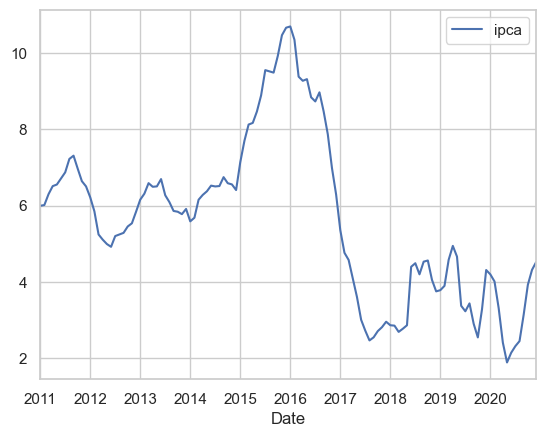

In [90]:
df_ipca.plot()

In [112]:
# obter os dados da série 432 da taxa SELIC
# SELIC ao ano (%) — série 432 no SGS/BCB
df_selic = sgs.get({'selic': 432}, start, end)

# Salvar o dataframe em um arquivo CSV
df_selic.to_csv('data/raw/selic.csv', encoding='utf-8')


Exception: Download error: code = 432

In [117]:
# Carregar o arquivo CSV com o separador correto, definindo a coluna 'Date' como índice e convertendo para datetime
df_selic = pd.read_csv(
    'data/raw/selic.csv',
    sep=';',
    index_col='Date',
    parse_dates=True,
    dayfirst=True
)

# Converter os valores da coluna 'selic' de string para float (substituir vírgula por ponto)
df_selic['selic'] = df_selic['selic'].astype(str).str.replace(',', '.').astype(float)

# O index já está corrigido para as datas reais. Apenas garantir tipo datetime:
df_selic.index = pd.to_datetime(df_selic.index, dayfirst=True)
#df_selic.columns = ['selic']

In [118]:
df_selic.head()

,selic
Date,
2010-10-01,10.75
2010-10-02,10.75
2010-10-03,10.75
2010-10-04,10.75
2010-10-05,10.75


<Axes: xlabel='Date'>

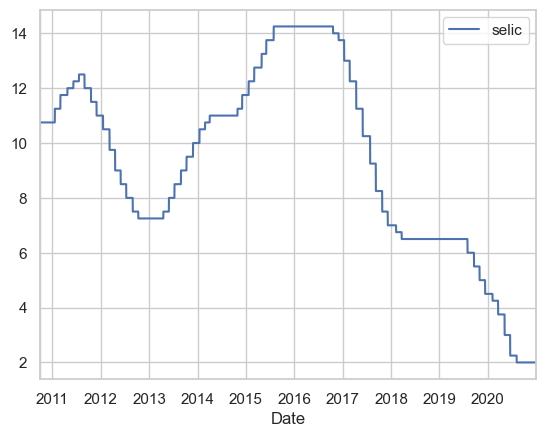

In [119]:
df_selic.plot()

In [120]:
df_final = pd.merge(df_selic, df_ipca, left_index=True, right_index=True, how='inner')
df_final.head()

,selic,ipca
Date,,
2011-01-01,10.75,5.993165
2011-02-01,11.25,6.014199
2011-03-01,11.25,6.298957
2011-04-01,11.75,6.510350
2011-05-01,12.00,6.552772


<Axes: xlabel='Date'>

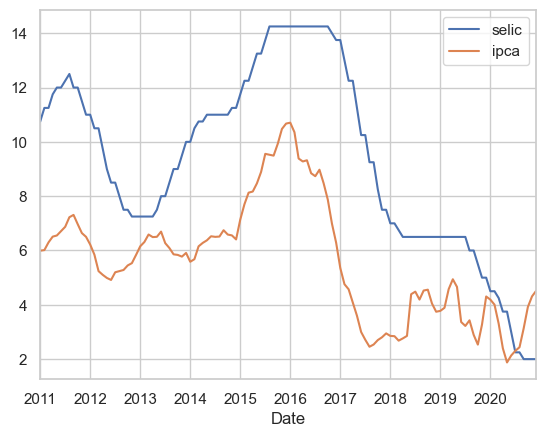

In [121]:
df_final.plot()

### 1.2 Carregar Séries Salvas Localmente

In [54]:
# Carregar os dados já tratados de IPCA e SELIC
ipca = pd.read_csv('data/raw/ipca.csv')
selic = pd.read_csv('data/raw/selic.csv')

# Os dataframes possuem o índice como datas já no formato correto
# Vamos garantir que o índice é datetime para ambos
ipca.index = pd.to_datetime(ipca.index)
selic.index = pd.to_datetime(selic.index)

# Renomear as colunas (caso não estejam já como 'ipca' e 'selic')
ipca = ipca.rename(columns={'ipca': 'ipca'})
selic = selic.rename(columns={'selic': 'selic'})

# Fazer o join pelo índice
df = pd.merge(selic, ipca, left_index=True, right_index=True, how='inner')

df = df.sort_index().reset_index().rename(columns={'index': 'Date'})

df.head()


,Date,Date_x,selic,Date_y,ipca
0,1970-01-01 00:00:00.000000000,2019-01-01,6.5,2019-01-01,3.776516
1,1970-01-01 00:00:00.000000001,2019-01-02,6.5,2019-02-01,3.890306
2,1970-01-01 00:00:00.000000002,2019-01-03,6.5,2019-03-01,4.575365
3,1970-01-01 00:00:00.000000003,2019-01-04,6.5,2019-04-01,4.940576
4,1970-01-01 00:00:00.000000004,2019-01-05,6.5,2019-05-01,4.658365


In [122]:
#Ver a uma estatística descritiva para ter noção da base de dados
df_final.describe()

,selic,ipca
count,120.000000,120.000000
mean,9.320833,5.642671
std,3.444973,2.179833
min,2.000000,1.877488
25%,6.500000,3.983247
50%,9.625000,5.805951
75%,12.000000,6.654534
max,14.250000,10.706293


### 2. Preparo Inicial (2019–2020)

In [129]:
df_preparo = df_final['2019-01-01':'2020-12-31']

In [132]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_preparo.index,
    y=df_preparo['selic'],
    mode='lines+markers',
    name='Selic',
    line=dict(color='royalblue'),
    marker=dict(size=6)
))

fig.add_trace(go.Scatter(
    x=df_preparo.index,
    y=df_preparo['ipca'],
    mode='lines+markers',
    name='IPCA',
    line=dict(color='darkorange'),
    marker=dict(size=6)
))

fig.update_layout(
    title='Séries Temporais: Selic e IPCA (2019–2020)',
    xaxis_title='Data',
    yaxis_title='Valor (% a.a.)',
    template='plotly_white',
    legend_title='Indicador'
)

fig.show()


In [ ]:
import statsmodels.formula.api as smf

rselic = smf.ols('selic ~ ipca', data=df_preparo).fit()
print(rselic.summary())

                            OLS Regression Results                            
Dep. Variable:                  selic   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.132
Date:                Tue, 21 Oct 2025   Prob (F-statistic):              0.158
Time:                        19:14:00   Log-Likelihood:                -46.211
No. Observations:                  24   AIC:                             96.42
Df Residuals:                      22   BIC:                             98.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4753      1.466      1.689      0.1

#### 2.1 Resultado da Regressão (2019–2020):

$$\text{Selic} = \beta_0 + \beta_1 \times \text{IPCA}$$

$$\text{SELIC} = 2.4753 + 0.5976 \times \text{IPCA}$$

#### 2.2 Plotar Regressão Linear Simples — Preparo (2019–2020)

In [127]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    df_preparo,
    x='ipca',
    y='selic',
    trendline='ols',
    trendline_color_override='crimson',
    labels={'ipca': 'IPCA (% a.a.)', 'selic': 'Selic (% a.a.)'},
    title='Relação Linear Simples entre IPCA e Selic',
    template='plotly_white',
    opacity=0.75
)

# Marcadores mais legíveis
fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='white')))

# Equação e R² do OLS
try:
    res = px.get_trendline_results(fig).iloc[0]['px_fit_results']
    b0 = res.params.get('const', float('nan'))
    b1 = res.params.get('ipca', float('nan'))
    r2 = res.rsquared
    eq = f"Selic = {b0:.2f} + {b1:.2f} × IPCA   (R²={r2:.2f})"
    fig.add_annotation(xref='paper', yref='paper', x=0.02, y=1.12, text=eq,
                       showarrow=False, font=dict(size=12, color='crimson'))
except Exception:
    pass

fig.update_layout(
    title=dict(x=0.02, xanchor='left'),
    hovermode='closest',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
)
fig.update_xaxes(showgrid=True, zeroline=False)
fig.update_yaxes(showgrid=True, zeroline=False)

fig.show()

### 3. Análise com base de dados estendida (2011–2020)

In [126]:
import statsmodels.formula.api as smf

df_extendido = df_final['2011-01-01':'2020-12-31']

rselic = smf.ols('selic ~ ipca', data=df_extendido).fit()
print(rselic.summary())

                            OLS Regression Results                            
Dep. Variable:                  selic   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     202.8
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           2.16e-27
Time:                        19:14:26   Log-Likelihood:                -258.19
No. Observations:                 120   AIC:                             520.4
Df Residuals:                     118   BIC:                             526.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2304      0.533      4.181      0.0

#### 3.1 Resultado da Regressão (2011–2020):

$$\text{Selic} = \beta_0 + \beta_1 \times \text{IPCA}$$

$$\text{SELIC} = 2.2304 + 1.2566 \times \text{IPCA}$$

#### 3.2 Plotar Regressão Linear Simples — Estendido (2011–2020)

In [128]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(
    df_extendido,
    x='ipca',
    y='selic',
    trendline='ols',
    trendline_color_override='crimson',
    labels={'ipca': 'IPCA (% a.a.)', 'selic': 'Selic (% a.a.)'},
    title='Relação Linear Simples entre IPCA e Selic',
    template='plotly_white',
    opacity=0.75
)

# Marcadores mais legíveis
fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='white')))

# Equação e R² do OLS
try:
    res = px.get_trendline_results(fig).iloc[0]['px_fit_results']
    b0 = res.params.get('const', float('nan'))
    b1 = res.params.get('ipca', float('nan'))
    r2 = res.rsquared
    eq = f"Selic = {b0:.2f} + {b1:.2f} × IPCA   (R²={r2:.2f})"
    fig.add_annotation(xref='paper', yref='paper', x=0.02, y=1.12, text=eq,
                       showarrow=False, font=dict(size=12, color='crimson'))
except Exception:
    pass

fig.update_layout(
    title=dict(x=0.02, xanchor='left'),
    hovermode='closest',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
)
fig.update_xaxes(showgrid=True, zeroline=False)
fig.update_yaxes(showgrid=True, zeroline=False)

fig.show()

In [62]:
# Regressão linear simples: Selic (nominal) ~ IPCA (anualizado)
import statsmodels.api as sm

def run_simple_regression(df_in: pd.DataFrame, start: str, end: str):
    # Garante que o índice é datetime e faz o filtro corretamente
    df_temp = df_in.copy()
    if not isinstance(df_temp.index, pd.DatetimeIndex):
        if 'Date' in df_temp.columns:
            df_temp['Date'] = pd.to_datetime(df_temp['Date'])
            df_temp.set_index('Date', inplace=True)
        else:
            df_temp.index = pd.to_datetime(df_temp.index)
    mask = (df_temp.index >= pd.to_datetime(start)) & (df_temp.index <= pd.to_datetime(end))
    subset = df_temp.loc[mask].copy()
    # Corrige nomes de colunas conforme esperado no resto do código
    subset = subset.dropna(subset=['selic', 'ipca'])
    
    # Verificação defensiva para evitar erro de array vazio
    if subset.empty:
        raise ValueError(f"Nenhum dado após filtragem entre {start} e {end} com colunas não nulas 'selic' e 'ipca'.")
    
    y = subset['selic']
    X = subset[['ipca']]
    X = sm.add_constant(X)
    
    # Novamente, verifica se X e y são compatíveis e têm dados
    if X.shape[0] == 0 or y.shape[0] == 0:
        raise ValueError(f"Subset para regressão está vazio após filtragem entre {start} e {end}.")
    
    model = sm.OLS(y, X).fit()
    return subset, model

# Janela 2019-2020
try:
    sub_1920, model_1920 = run_simple_regression(df_final, '2019-01-01', '2020-12-31')
    display(model_1920.summary())
except ValueError as ve:
    print("Erro ao rodar a regressão (2019-2020):", ve)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  selic   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.132
Date:                Tue, 21 Oct 2025   Prob (F-statistic):              0.158
Time:                        18:07:15   Log-Likelihood:                -46.211
No. Observations:                  24   AIC:                             96.42
Df Residuals:                      22   BIC:                             98.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4753      1.466      1.689      0.105      -0.565       5.515
ipca           0.5976      0.409      1.460      0.158      -0.251       1.447
==============================================================================
Omnibus:                        2.815   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.032
Skew:                          -0.542   Prob(JB):                        0.362
Kurtosis:                       2.075   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# Métricas e equação para 2019-2020
params = model_1920.params
r2 = model_1920.rsquared
r2_adj = model_1920.rsquared_adj
pvalues = model_1920.pvalues

beta0 = params.get('const', np.nan)
beta1 = params.get('ipca_aa', np.nan)

equation = f"Selic = {beta0:.4f} + {beta1:.4f} * IPCA"
print(equation)
print({
    'R2': r2,
    'R2_adj': r2_adj,
    't_beta1': model_1920.tvalues.get('ipca_aa', np.nan),
    'p_beta1': pvalues.get('ipca_aa', np.nan),
})


Selic = 2.4753 + nan * IPCA
{'R2': 0.08833091646092661, 'R2_adj': 0.04689141266369601, 't_beta1': nan, 'p_beta1': nan}


In [ ]:
# Janela 2011-2020
sub_1120, model_1120 = run_simple_regression(df, '2011-01-01', '2020-12-31')
model_1120.summary()


In [ ]:
# Métricas e equação para 2011-2020
params2 = model_1120.params
r2_2 = model_1120.rsquared
r2_adj_2 = model_1120.rsquared_adj
pvalues2 = model_1120.pvalues

beta0_2 = params2.get('const', np.nan)
beta1_2 = params2.get('ipca_aa', np.nan)

equation2 = f"Selic_aa = {beta0_2:.4f} + {beta1_2:.4f} * IPCA_aa"
print(equation2)
print({
    'R2': r2_2,
    'R2_adj': r2_adj_2,
    't_beta1': model_1120.tvalues.get('ipca_aa', np.nan),
    'p_beta1': pvalues2.get('ipca_aa', np.nan),
})


## 4. Análise e Discussão
- Compare R² entre janelas (2019–2020 vs 2011–2020).
- Avalie significância (teste t, p-valor) do coeficiente de IPCA.
- Interprete a equação estimada e impactos econômicos.
- Discuta se indicadores melhoram/pioram ao ampliar a janela.
